# Libraries

In [10]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import time

from sklearn.metrics import RocCurveDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


from sklearn.metrics import roc_curve, auc
from itertools import cycle # for cycling through colors




## Graphics and options

In [2]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

## Functions

The following cell contains the functions that we use in this notebook.

In [12]:
def choose_best_thres(y_true, y_pred_proba):
    '''
    Returns a threshold between 0.1 and 0.9
    which maximizes the macro average f1-score,
    for a multilabel classification problem.

    Parameters:
        - y_true: binary array
        - y_pred_proba: array
            returned by some_estimator.predict_proba()
    '''
    f1_thr = {}
    for t in np.linspace(0.1,0.9,9): # testing thresholds 0.2, 0.3, up to 0.8
        classif_rep = classification_report(
            y_true, 
            (y_pred_proba > t).astype(int),
            target_names=tag_list,
            output_dict=True)
        f1_thr[t] =  classif_rep['macro avg']['f1-score']

    # choose threshold for maximal f1-score
    thresh = round(max(f1_thr, key=f1_thr.get),1)
    print(f'Threshold that maximizes f1-score: {thresh}')

    return thresh


def plot_classif_report(classif_report, tag_list, model_name, dataset_name):
    '''
    Plots precision, recall and f1-score for each tag in tag_list.

    Parameters:
        - classif_report: dict
            It is the output of sklearn.metrics.classification_report(y_true,y_pred)
            after a multi-label multi-output classification.
        - tag_list: list of str
            The list of tags of the classification.
        - model_name, dataset_name: str
            for the title of the plot
    '''
    n_tags = len(tag_list)

    fig = plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.xticks(range(1,len(tag_list)+1),tag_list)
    colors = ['blueviolet', 'darkorange', 'dodgerblue']

    for metric,color in zip(['precision', 'recall', 'f1-score'], colors):
        y = [classif_report[tag][metric] for tag in tag_list]
        plt.scatter(range(1,n_tags+1),y,label=metric, c=color)
    plt.legend()
    plt.ylim(0,1.1)

    macro_prec = round(classif_report['macro avg']['precision'],2)
    macro_rec = round(classif_report['macro avg']['recall'],2)
    macro_f1 = round(classif_report['macro avg']['f1-score'],2)

    plt.text(9, 
             0.05, 
             f'Macro avg\nprecision: {macro_prec}\nrecall: {macro_rec}\nf1-score: {macro_f1}',
             bbox={'facecolor':'white', 'alpha':0.5})
    plt.title(f'Some metrics by tag\nModel: {model_name}, set: {dataset_name}')
    plt.show()

def diplay_and_plot_report(y_true, y_pred, model_name, dataset_name):
        '''
        Displays the classification report together with the metrics
        (from the mul-label, multi-output classification) and plots
        the metrics for each tag.

        Parameters:
                - y_true: array
                        The true labels
                - y_pred: array
                        The prefictions
                - model_name, dataset_name: str
                        For the title of the plot
        '''

        classif_rep = classification_report(
                y_true, 
                y_pred,
                target_names=tag_list,
                output_dict=True)
        classif_rep_displ = classification_report(
                y_true, 
                y_pred,
                target_names=tag_list,
                output_dict=False)
        print(f'Classifier: {model_name}\tDataset: {dataset_name}')
        print('-'*70)
        print(classif_rep_displ)
        plot_classif_report(classif_rep, tag_list, model_name, dataset_name)

def compute_roc_data(y_true,y_pred_proba,tag_list):
    '''
    Computes the data necessary to plot the OneVsRest
    ROC curves of our multilabel classification.
    Returns dictionnaries: fpr, tpr, roc_auc

    Based on sckikit-learn's example: 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

    Parameters:
        - y_true: pd.DataFrame
        - y_pred: array
            returned by classification: predict probabilities
        - tag_list: list of str 
    '''

    n_tags = len(tag_list)
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.values.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")


    for i in range(n_tags):
        fpr[i], tpr[i], _ = roc_curve(y_true.values[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_tags):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_tags

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

    return fpr, tpr, roc_auc



def plot_roc_curves(
        fpr, tpr, roc_auc, model_name, dataset_name,y_true,y_pred_proba):
    '''
    Plots the ROC curves of the OneVsRest classification
    for each tag.

    Based on scikit-learn's example:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

    Parameters:
        - fpr, tpr, roc_auc: dict, dict, dict
            Output of the function compute_roc_data
        - model_name, dataset_name: str
            For the title of the plot
    '''
    

    fig, ax = plt.subplots(figsize=(6, 6))

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=3,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=3,
    )

    colors = cycle(["darkorange", 
                    'olivedrab', 
                    'lightseagreen',
                    'dodgerblue',
                    'slategray',
                    'blueviolet',
                    'indigo',
                    'mediumvioletred',
                    'lightgreen',
                    'lightpink'
                    ])
    for (idx,class_id), color in zip(enumerate(tag_list), colors):
        RocCurveDisplay.from_predictions(
            y_true[f'tag_{class_id}'].values,
            y_pred_proba[:, idx],
            name=f"ROC curve for {class_id}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curves and AUC for each tag\nto One-vs-Rest\nmodel: {model_name}, dataset: {dataset_name}")
    plt.legend()
    plt.show()


# Data

In [3]:
path = './data/'
filename = 'processed_data_v01.csv'

df = pd.read_csv(path + filename, converters={'Tags': pd.eval})
df.set_index('Id', inplace=True)

tag_list = [tag[4:] for tag in list(df.columns) if 'tag' in tag]

In [4]:
df.head()

,processed_text,text,Title,Body,Score,ViewCount,AnswerCount,Tags,tag_c#,tag_java,tag_javascript,tag_python,tag_c++,tag_ios,tag_android,tag_.net,tag_html,tag_php
Id,,,,,,,,,,,,,,,,,,
4,decimal c# variable opacity app error type,How to convert Decimal to Double in C#? <p>I w...,How to convert Decimal to Double in C#?,<p>I want to assign the decimal variable &quot...,792,70052,14,[c#],1,0,0,0,0,0,0,0,0,0
11,time c# value time,Calculate relative time in C# <p>Given a speci...,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,1644,196587,41,[c#],1,0,0,0,0,0,0,0,0,0
13,user timezone way web server user timezone web...,Determine a user's timezone <p>Is there a stan...,Determine a user's timezone,<p>Is there a standard way for a web server to...,698,274233,27,[html],0,0,0,0,0,0,0,0,1,0
25,c socket api c++ z os issue c socket api c++ z...,How to use the C socket API in C++ on z/OS <p>...,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,175,15797,9,[c++],0,0,0,0,1,0,0,0,0,0
109,t sql cast c#/vb.net site resurgence asprox sq...,Decoding T-SQL CAST in C#/VB.NET <p>Recently o...,Decoding T-SQL CAST in C#/VB.NET,<p>Recently our site has been deluged with the...,69,6068,2,[c#],1,0,0,0,0,0,0,0,0,0


In [5]:
df.loc[df.processed_text.isna()]

,processed_text,text,Title,Body,Score,ViewCount,AnswerCount,Tags,tag_c#,tag_java,tag_javascript,tag_python,tag_c++,tag_ios,tag_android,tag_.net,tag_html,tag_php
Id,,,,,,,,,,,,,,,,,,
14269587,NaN,How to execute <script> code in a javascript a...,How to execute <script> code in a javascript a...,<p>I'm working with a plugin that is only Java...,15,30125,6,"[javascript, html]",0,0,1,0,0,0,0,0,1,0


In [6]:
df.drop(index=14269587, inplace=True)

# Bag of words: TF-IDF

## Vectorizing texts

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate the vectorizer
tfidf = TfidfVectorizer(max_df=0.8,
                     min_df=0.001
                     )

# Vectorize the processed text
X = tfidf.fit_transform(df.processed_text)

# Defining target vector
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.33, random_state=5
)

In [8]:
X.shape

(31928, 1973)

## Classification (supervised)

Our tag suggesting problem is a Multilabel classification problem. For this, we use the OneVsRest strategy (and tool by scikit-learn), which trains/predicts one estimator per label. See [OneVsRest scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier), the [scikit-learn module on article about multilabel classif](https://scikit-learn.org/stable/modules/multiclass.html#onevsrestclassifier) and a [scikit-learn example on multilabel classif.](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_multilabel.html#sphx-glr-auto-examples-miscellaneous-plot-multilabel-py)

For the **evaluation** of the models we base on the scikit-learn example : [ROC AUC for multilabel](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py), and we use the **macro average** for f1-score and ROC AUC. Since this way of averaging considers each tag as having the same importance (see this [stack exchange question](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin)).

We used this Stackoverflow discussion about [Fine tuning estimator inside OneVsRestClassifier](https://stackoverflow.com/questions/12632992/gridsearch-for-an-estimator-inside-a-onevsrestclassifier).

- More on [Multiclass and multilabel classification](https://scikit-learn.org/stable/modules/model_evaluation.html#multiclass-and-multilabel-classification).

### LogisticRegression

We find the best hyperparameters first, optimizing the macro average for ROC-AUC

In [14]:
# Hyperparameters for logistic regression
parameters = {
    'estimator__penalty' : ['l1', 'l2', 'elasticnet'],
    'estimator__dual' : [True, False],
    'estimator__tol' : [1e-6, 1e-5, 1e-4],
    'estimator__C' : [0.05 ,0.1, 0.5, 0.7, 1],
    'estimator__fit_intercept' : [True, False],
    'estimator__solver' : ['liblinear','sag', 'saga'],
    'estimator__l1_ratio' : [0.3, 0.5, 0.7]
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(LogisticRegression())

# Random search for best hyperparameters
random_search = RandomizedSearchCV(
    estimator = cl,
    param_distributions= parameters,
    n_iter=40,
    scoring='roc_auc_ovr',
    random_state=5,
    n_jobs=-1
)

# Perform random search
random_search.fit(X_train, y_train)

# Instantiating BEST OneVsRest Classifier
cl = random_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
print(f'fit time: {finish - start} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

# Print best parameters
print('The best parameters are:')
print(random_search.best_params_)
print('The best score is:')
print(random_search.best_score_)

/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/pyth

fit time: 1.2205357551574707 secs.
predict time: 0.008436918258666992 secs.
The best parameters are:
{'estimator__tol': 0.0001, 'estimator__solver': 'saga', 'estimator__penalty': 'l2', 'estimator__l1_ratio': 0.3, 'estimator__fit_intercept': True, 'estimator__dual': False, 'estimator__C': 1}
The best score is:
0.9524409957505515


In [15]:
# Choosing best classification threshold
thresh = choose_best_thres(y_train, y_pred_train_proba)

# Predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.3


#### Evaluation: LogisticRegression

Classifier: LogisticRegression	Dataset: train
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.72      0.80      0.76      4019
        java       0.88      0.76      0.82      3584
  javascript       0.82      0.81      0.81      3119
      python       0.95      0.85      0.90      3092
         c++       0.82      0.79      0.80      2496
         ios       0.89      0.81      0.85      2208
     android       0.93      0.79      0.85      1928
        .net       0.59      0.47      0.52      2060
        html       0.70      0.66      0.68      1382
         php       0.94      0.74      0.83      1317

   micro avg       0.82      0.76      0.79     25205
   macro avg       0.82      0.75      0.78     25205
weighted avg       0.82      0.76      0.79     25205
 samples avg       0.76      0.79      0.76     25205



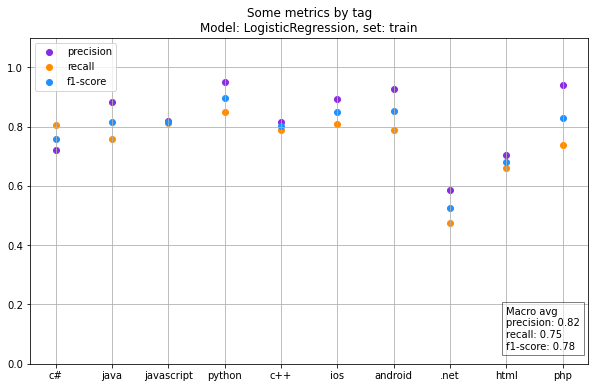

In [16]:
diplay_and_plot_report(y_train, y_pred_train, 'LogisticRegression', 'train')

Classifier: LogisticRegression	Dataset: test
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.68      0.75      0.71      1920
        java       0.86      0.72      0.78      1761
  javascript       0.79      0.75      0.77      1592
      python       0.93      0.82      0.87      1430
         c++       0.78      0.70      0.74      1276
         ios       0.87      0.75      0.81      1123
     android       0.91      0.77      0.83       974
        .net       0.53      0.39      0.45      1002
        html       0.68      0.56      0.61       745
         php       0.92      0.68      0.78       634

   micro avg       0.79      0.71      0.75     12457
   macro avg       0.79      0.69      0.73     12457
weighted avg       0.79      0.71      0.74     12457
 samples avg       0.71      0.73      0.70     12457



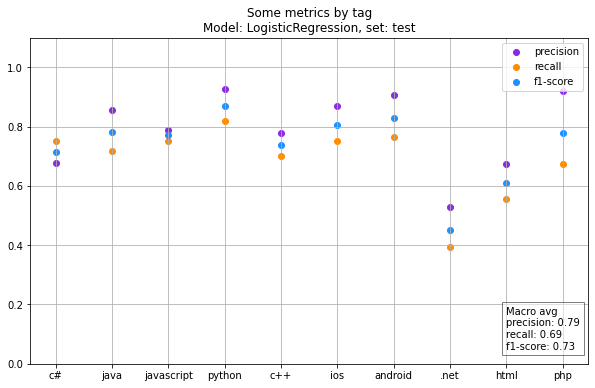

In [17]:
diplay_and_plot_report(y_test, y_pred_test, 'LogisticRegression', 'test')

In [18]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.97
Macro-averaged One-vs-Rest ROC AUC score:
0.97


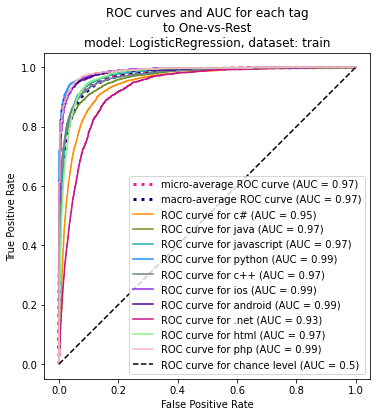

In [19]:
plot_roc_curves(
    fpr,tpr,roc_auc,'LogisticRegression', 'train',y_train, y_pred_train_proba)

In [20]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.96
Macro-averaged One-vs-Rest ROC AUC score:
0.95


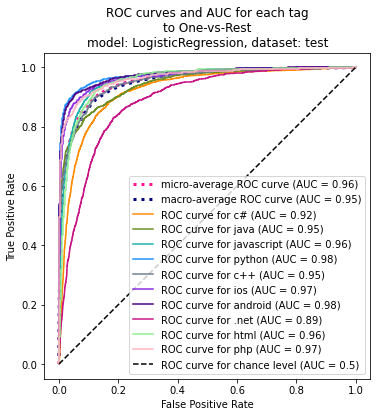

In [21]:
plot_roc_curves(
    fpr,tpr,roc_auc,'LogisticRegression', 'test',y_test, y_pred_test_proba)

### Naive-Bayes classifier (TD-IDF)

In [23]:
parameters = {
    'estimator__alpha' : [0.05, 0.2, 0.5, 1],
    'estimator__fit_prior' : [True, False]
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(MultinomialNB())

# Grid search for best hyperparameters
grid_search = GridSearchCV(
    estimator = cl,
    param_grid= parameters,
    scoring='roc_auc_ovr',
    verbose=2,
    n_jobs=-1
)

# Performing grid search
grid_search.fit(X_train, y_train)

# Instantiating Best OneVsRest Classifier
cl = grid_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
print(f'fit time: {finish - start} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

# Print best parameters
print('The best parameters are:')
print(grid_search.best_params_)
print('The best score is:')
print(grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   0.3s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   0.3s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   0.5s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   0.5s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   0.6s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   0.6s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   0.7s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   0.7s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   0.5s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   0.4s
[CV] END ....estimator__alpha=0.2, estimator__fit_prior=True; total time=   0.3s
[CV] END ....estimator__alpha=0.2, estimator__fit

In [24]:
# Choosing best threshold for classification
thresh = choose_best_thres(y_train, y_pred_train_proba)

# predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.2


#### Evaluation: NaiveBayes

Classifier: MultinomialNB	Dataset: train
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.61      0.87      0.72      4019
        java       0.67      0.81      0.73      3584
  javascript       0.64      0.87      0.74      3119
      python       0.75      0.89      0.81      3092
         c++       0.65      0.85      0.73      2496
         ios       0.74      0.85      0.79      2208
     android       0.75      0.82      0.79      1928
        .net       0.50      0.61      0.55      2060
        html       0.53      0.76      0.63      1382
         php       0.81      0.75      0.78      1317

   micro avg       0.66      0.82      0.73     25205
   macro avg       0.66      0.81      0.73     25205
weighted avg       0.66      0.82      0.73     25205
 samples avg       0.71      0.84      0.74     25205



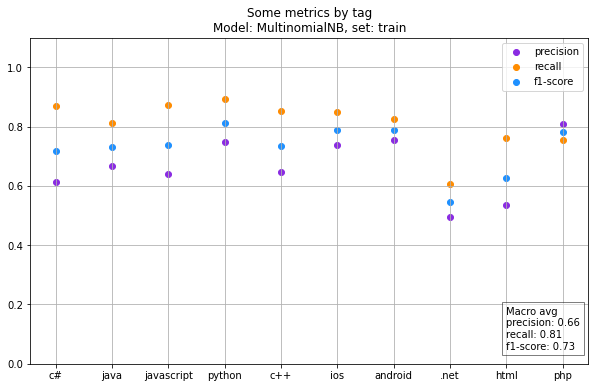

In [25]:
diplay_and_plot_report(y_train, y_pred_train, 'MultinomialNB', 'train')

Classifier: MultinomialNB	Dataset: test
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.58      0.84      0.69      1920
        java       0.64      0.78      0.70      1761
  javascript       0.63      0.84      0.72      1592
      python       0.71      0.86      0.78      1430
         c++       0.63      0.80      0.71      1276
         ios       0.70      0.78      0.74      1123
     android       0.72      0.80      0.76       974
        .net       0.44      0.50      0.47      1002
        html       0.53      0.69      0.60       745
         php       0.80      0.69      0.74       634

   micro avg       0.63      0.78      0.70     12457
   macro avg       0.64      0.76      0.69     12457
weighted avg       0.63      0.78      0.70     12457
 samples avg       0.67      0.80      0.70     12457



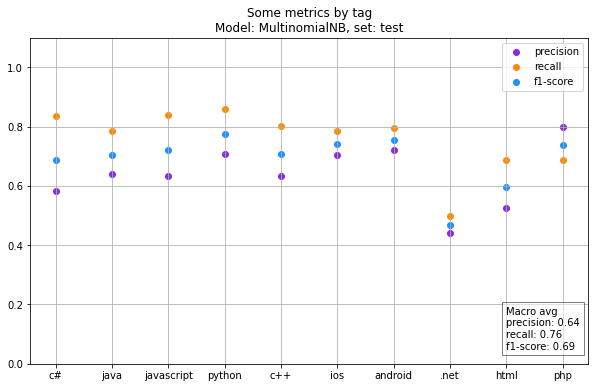

In [74]:
diplay_and_plot_report(y_test, y_pred_test, 'MultinomialNB', 'test')

In [26]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.96
Macro-averaged One-vs-Rest ROC AUC score:
0.96


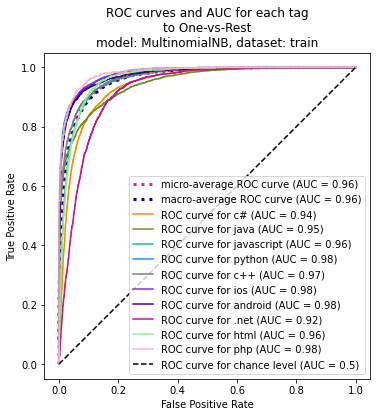

In [28]:
plot_roc_curves(
    fpr,tpr,roc_auc,'MultinomialNB', 'train',y_train, y_pred_train_proba)

In [29]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.95
Macro-averaged One-vs-Rest ROC AUC score:
0.94


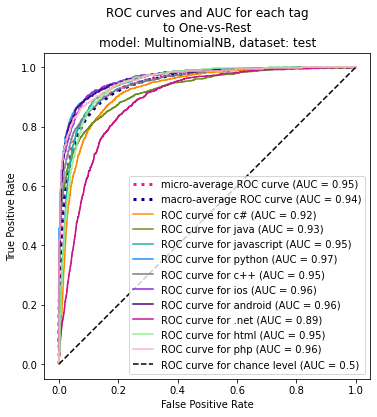

In [30]:
plot_roc_curves(
    fpr,tpr,roc_auc,'MultinomialNB', 'test',y_test, y_pred_test_proba)

### RandomForestClassifier

We tried to fine tune this random forest classifier, but it took so long. One strategy is to execute this random search on google collab. For the moment we leave the search as a commented cell and we use the default hyperparameters to compare.

In [32]:
# # Hyperparameter tuning for RandomForest

# parameters = {
#     'estimator__n_estimators' : [50, 100, 150, 200, 250],
#     'estimator__max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
#     'estimator__min_samples_split' : [2,5,10],
#     'estimator__min_samples_leaf' : [1,2,4],
#     'estimator__bootstrap' : [True, False],
#     'estimator__max_features' : ['sqrt', 'log2', None]
# }

# # Instantiating OneVsRest Classifier
# cl = OneVsRestClassifier(RandomForestClassifier())

# # Random search for best hyperparameters
# random_search = RandomizedSearchCV(
#     estimator = cl,
#     param_distributions= parameters,
#     n_iter=30,
#     scoring='roc_auc_ovr',
#     verbose=2,
#     random_state=5,
#     n_jobs=-1
# )

# # Perform random search
# random_search.fit(X_train, y_train)

# # Instantiating OneVsRest Classifier default parameters
# cl = random_search.best_estimator_

# # Fitting classifier
# start = time.time()
# cl.fit(X_train,y_train)
# finish = time.time()
# print(f'fit time: {finish - start} secs.')

# # Predicting (with probabilites)
# start = time.time()
# y_pred_train_proba = cl.predict_proba(X_train)
# finish = time.time()
# print(f'predict time: {finish - start} secs.')

# y_pred_test_proba = cl.predict_proba(X_test)

# # Print best parameters
# print('The best parameters are:')
# print(random_search.best_params_)
# print('The best score is:')
# print(random_search.best_score_)


In [33]:
# Instantiating OneVsRest Classifier default parameters
cl = OneVsRestClassifier(RandomForestClassifier())

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
print(f'fit time: {finish - start} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

fit time: 152.28099942207336 secs.
predict time: 11.860923051834106 secs.


In [34]:
# choose threshold for maximal f1-score
thresh = choose_best_thres(y_train, y_pred_train_proba)

# predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.5


#### Evaluation: RandomForestClassifier

Classifier: RandomForestClassifier	Dataset: train
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       1.00      1.00      1.00      4019
        java       1.00      1.00      1.00      3584
  javascript       1.00      1.00      1.00      3119
      python       1.00      1.00      1.00      3092
         c++       1.00      1.00      1.00      2496
         ios       1.00      1.00      1.00      2208
     android       1.00      1.00      1.00      1928
        .net       1.00      1.00      1.00      2060
        html       1.00      1.00      1.00      1382
         php       1.00      1.00      1.00      1317

   micro avg       1.00      1.00      1.00     25205
   macro avg       1.00      1.00      1.00     25205
weighted avg       1.00      1.00      1.00     25205
 samples avg       1.00      1.00      1.00     25205



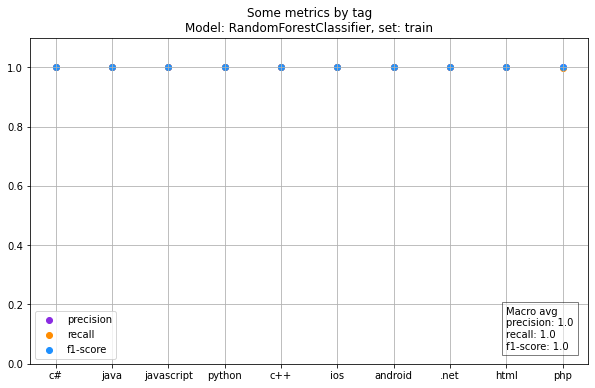

In [35]:
diplay_and_plot_report(y_train, y_pred_train, 'RandomForestClassifier', 'train')

Classifier: RandomForestClassifier	Dataset: test
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.79      0.52      0.63      1920
        java       0.88      0.71      0.79      1761
  javascript       0.83      0.72      0.77      1592
      python       0.95      0.83      0.88      1430
         c++       0.91      0.54      0.68      1276
         ios       0.91      0.77      0.83      1123
     android       0.90      0.79      0.84       974
        .net       0.67      0.11      0.19      1002
        html       0.76      0.32      0.45       745
         php       0.91      0.74      0.82       634

   micro avg       0.87      0.62      0.72     12457
   macro avg       0.85      0.60      0.69     12457
weighted avg       0.85      0.62      0.70     12457
 samples avg       0.67      0.65      0.65     12457



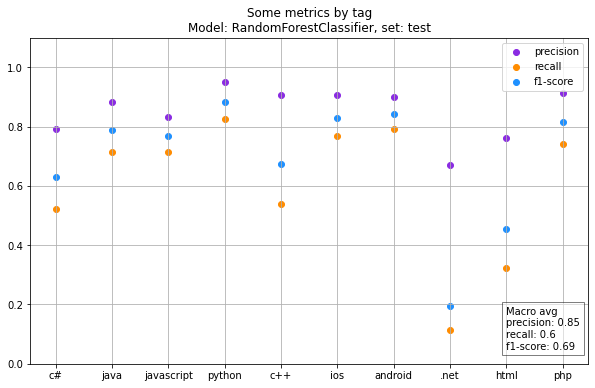

In [36]:
diplay_and_plot_report(y_test, y_pred_test, 'RandomForestClassifier', 'test')

In [37]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
1.00
Macro-averaged One-vs-Rest ROC AUC score:
1.00


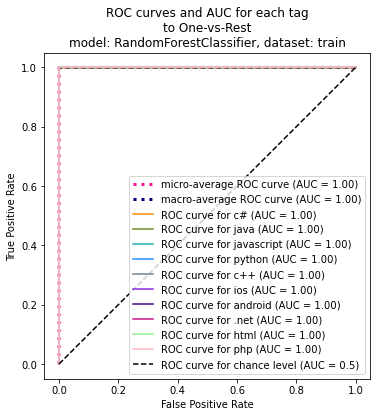

In [38]:
plot_roc_curves(
    fpr,tpr,roc_auc,'RandomForestClassifier', 'train',y_train, y_pred_train_proba)

In [39]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.94
Macro-averaged One-vs-Rest ROC AUC score:
0.94


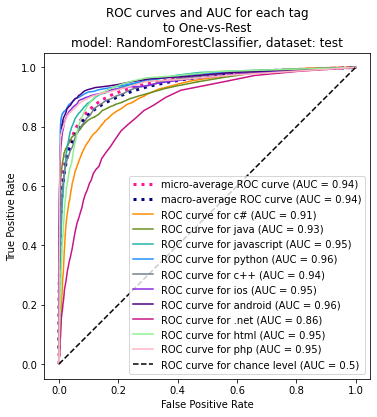

In [40]:
plot_roc_curves(
    fpr,tpr,roc_auc,'RandomForestClassifier', 'test',y_test, y_pred_test_proba)

# Word2vec

In [41]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

2023-02-24 15:34:32.692951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 15:34:33.398650: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-24 15:34:33.398737: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-24 15:34:35.335327: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [42]:
df.processed_text.apply(lambda x:len(x.split())).describe()

count    31928.000000
mean        32.543535
std         23.032481
min          1.000000
25%         17.000000
50%         27.000000
75%         41.000000
max        371.000000
Name: processed_text, dtype: float64

In [178]:
df.head()

,processed_text,text,Title,Body,Score,ViewCount,AnswerCount,Tags,tag_c#,tag_java,tag_javascript,tag_python,tag_c++,tag_ios,tag_android,tag_.net,tag_html,tag_php
Id,,,,,,,,,,,,,,,,,,
4,decimal c# variable opacity app error type,How to convert Decimal to Double in C#? <p>I w...,How to convert Decimal to Double in C#?,<p>I want to assign the decimal variable &quot...,792,70052,14,[c#],1,0,0,0,0,0,0,0,0,0
11,time c# value time,Calculate relative time in C# <p>Given a speci...,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,1644,196587,41,[c#],1,0,0,0,0,0,0,0,0,0
13,user timezone way web server user timezone web...,Determine a user's timezone <p>Is there a stan...,Determine a user's timezone,<p>Is there a standard way for a web server to...,698,274233,27,[html],0,0,0,0,0,0,0,0,1,0
25,c socket api c++ z os issue c socket api c++ z...,How to use the C socket API in C++ on z/OS <p>...,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,175,15797,9,[c++],0,0,0,0,1,0,0,0,0,0
109,t sql cast c#/vb.net site resurgence asprox sq...,Decoding T-SQL CAST in C#/VB.NET <p>Recently o...,Decoding T-SQL CAST in C#/VB.NET,<p>Recently our site has been deluged with the...,69,6068,2,[c#],1,0,0,0,0,0,0,0,0,0


In [43]:
# Build & train Word2Vec model
print("Build & train Word2Vec model ...")

# Word2Vec model parameters
w2v_size=300
w2v_window=5
w2v_min_count=30
w2v_epochs=100 
maxlen = 25 # adapt to length of sentences
sentences = df['processed_text'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

# Instantiate model
w2v_model = gensim.models.Word2Vec(vector_size=w2v_size,
                                   window=w2v_window,
                                   min_count=w2v_min_count, 
                                    # max_final_vocab=2000,
                                   workers=1)
# Building vocabulary
w2v_model.build_vocab(sentences)

# Training the model
w2v_model.train(sentences, 
                total_examples=w2v_model.corpus_count, # Since = sentences to build
                epochs=w2v_epochs)

# Model vectors (words <--> embeddings)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key

print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 2700
Word2Vec trained


In [44]:
len(w2v_words)

2700

In [45]:
# Display some words of vocabulary
w2v_words[:15]

['code',
 'file',
 'way',
 'error',
 'class',
 'method',
 'app',
 'problem',
 'application',
 'function',
 'object',
 'user',
 'example',
 'time',
 'value']

In [138]:
w2v_words.insert(0,'')
w2v_words[:15]

['',
 'code',
 'file',
 'way',
 'error',
 'class',
 'method',
 'problem',
 'app',
 'application',
 'function',
 'object',
 'user',
 'time',
 'example']

In [46]:
# display the first 10 coordinates of the word python in our vocab.
w2v_model.wv['python'][:10]

array([ 0.58111286,  0.6975501 ,  0.21113932, -0.624876  , -0.71159804,
       -0.11999424, -0.18061703,  0.51714635, -1.9696882 , -1.2462679 ],
      dtype=float32)

In [47]:
# Display the most similar words to 'python'
w2v_model.wv.most_similar('python')

[('importerror', 0.4391450583934784),
 ('anaconda', 0.41681793332099915),
 ('virtualenv', 0.40076330304145813),
 ('numpy', 0.39995962381362915),
 ('pypy', 0.3928599953651428),
 ('pip', 0.3622334599494934),
 ('interpreter', 0.3445878326892853),
 ('pyqt', 0.34018653631210327),
 ('matplotlib', 0.3369998335838318),
 ('pygame', 0.3366183936595917)]

In [51]:
len(sentences)

31928

In [55]:
w2v_words[:10]

['code',
 'file',
 'way',
 'error',
 'class',
 'method',
 'app',
 'problem',
 'application',
 'function']

In [53]:
# Preparation of sentences (tokenization)
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(w2v_words) ############### fit on what!
sequences = tokenizer.texts_to_sequences(sentences)
x_sentences = pad_sequences(sequences,
                            maxlen=maxlen,
                            padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 2698


In [98]:
x_sentences[0]

array([1736,   79, 1479,   15,   12,   28,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [97]:
set(w2v_words) - set(tokenizer.word_index.keys())

{'mod_wsgi', 'node_modules', 'project_name', 'shared_ptr', 'unique_ptr'}

In [57]:
tokenizer.word_index

{'project': 1,
 'node': 2,
 'name': 3,
 'wsgi': 4,
 'modules': 5,
 'shared': 6,
 'ptr': 7,
 'mod': 8,
 'code': 9,
 'file': 10,
 'way': 11,
 'error': 12,
 'class': 13,
 'method': 14,
 'app': 15,
 'problem': 16,
 'application': 17,
 'function': 18,
 'object': 19,
 'user': 20,
 'example': 21,
 'time': 22,
 'value': 23,
 'datum': 24,
 'question': 25,
 'server': 26,
 'image': 27,
 'type': 28,
 'python': 29,
 'java': 30,
 'page': 31,
 'solution': 32,
 'library': 33,
 'string': 34,
 'test': 35,
 'view': 36,
 'android': 37,
 'issue': 38,
 'version': 39,
 'web': 40,
 'line': 41,
 'thank': 42,
 'html': 43,
 'case': 44,
 'api': 45,
 'list': 46,
 'request': 47,
 'text': 48,
 'result': 49,
 'array': 50,
 'net': 51,
 'thread': 52,
 'element': 53,
 'system': 54,
 'database': 55,
 'idea': 56,
 'property': 57,
 'service': 58,
 'thing': 59,
 'javascript': 60,
 'event': 61,
 'client': 62,
 'number': 63,
 'table': 64,
 'http': 65,
 'message': 66,
 'exception': 67,
 'memory': 68,
 'edit': 69,
 'php': 70,
 

## Creating embedding matrix

In [58]:
# Creation of the embedding matrix
print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  0.9993
Embedding matrix: (2698, 300)


## Embedding model

In [59]:
# Création du modèle
input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 25)]              0         
                                                                 
 embedding (Embedding)       (None, 25, 300)           809400    
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 809,400
Trainable params: 809,400
Non-trainable params: 0
_________________________________________________________________


2023-02-24 16:01:43.383545: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-24 16:01:43.383574: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-24 16:01:43.383600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nemo): /proc/driver/nvidia/version does not exist
2023-02-24 16:01:43.384539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [82]:
# Model execution
embeddings = embed_model.predict(x_sentences)
embeddings.shape

998/998 [==============================] - 3s 2ms/step


(31928, 300)

In [83]:
X = embeddings

# Defining target vector
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.33, random_state=5
)

## Classification (supervised)

### Logistic Regression

In [73]:
# Hyperparameters for logistic regression
parameters = {
    'estimator__penalty' : ['l1', 'l2', 'elasticnet'],
    'estimator__dual' : [True, False],
    'estimator__tol' : [1e-6, 1e-5, 1e-4],
    'estimator__C' : [0.05 ,0.1, 0.5, 0.7, 1],
    'estimator__fit_intercept' : [True, False],
    'estimator__solver' : ['liblinear','sag', 'saga'],
    'estimator__l1_ratio' : [0.3, 0.5, 0.7]
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(LogisticRegression())

# Random search for best hyperparameters
random_search = RandomizedSearchCV(
    estimator = cl,
    param_distributions= parameters,
    n_iter=20,
    scoring='roc_auc_ovr',
    random_state=5,
    n_jobs=-1
)

# Perform random search
random_search.fit(X_train, y_train)

# Instantiating BEST OneVsRest Classifier
cl = random_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
print(f'fit time: {finish - start} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/pyth

fit time: 33.33195447921753 secs.
predict time: 0.45748281478881836 secs.


In [74]:
# Print best parameters
print('The best parameters are:')
print(random_search.best_params_)
print('The best score is:')
print(random_search.best_score_)

The best parameters are:
{'estimator__tol': 1e-05, 'estimator__solver': 'liblinear', 'estimator__penalty': 'l1', 'estimator__l1_ratio': 0.7, 'estimator__fit_intercept': True, 'estimator__dual': False, 'estimator__C': 0.7}
The best score is:
0.9365953336862061


In [75]:
thresh = choose_best_thres(y_train, y_pred_train_proba)

# Predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.3


Classifier: LogisticRegression	Dataset: train
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.65      0.75      0.69      4019
        java       0.74      0.73      0.74      3584
  javascript       0.73      0.77      0.75      3119
      python       0.82      0.82      0.82      3092
         c++       0.74      0.75      0.74      2496
         ios       0.82      0.82      0.82      2208
     android       0.82      0.78      0.80      1928
        .net       0.49      0.44      0.46      2060
        html       0.63      0.62      0.63      1382
         php       0.79      0.73      0.76      1317

   micro avg       0.72      0.73      0.73     25205
   macro avg       0.72      0.72      0.72     25205
weighted avg       0.72      0.73      0.73     25205
 samples avg       0.70      0.76      0.71     25205



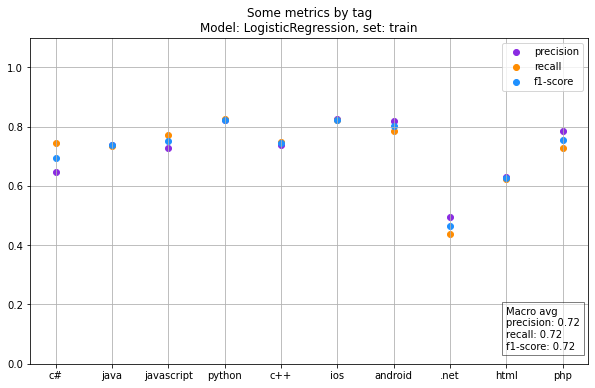

In [76]:
diplay_and_plot_report(y_train, y_pred_train, 'LogisticRegression', 'train')

Classifier: LogisticRegression	Dataset: test
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.62      0.73      0.67      1920
        java       0.73      0.71      0.72      1761
  javascript       0.72      0.76      0.74      1592
      python       0.80      0.82      0.81      1430
         c++       0.74      0.71      0.72      1276
         ios       0.79      0.77      0.78      1123
     android       0.78      0.77      0.78       974
        .net       0.46      0.41      0.44      1002
        html       0.63      0.55      0.59       745
         php       0.73      0.69      0.71       634

   micro avg       0.70      0.71      0.71     12457
   macro avg       0.70      0.69      0.70     12457
weighted avg       0.70      0.71      0.70     12457
 samples avg       0.67      0.73      0.68     12457



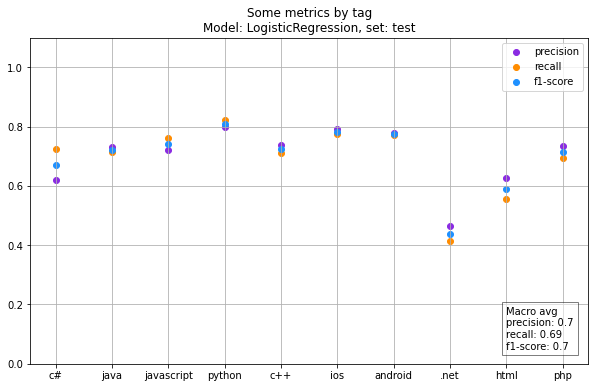

In [77]:
diplay_and_plot_report(y_test, y_pred_test, 'LogisticRegression', 'test')

In [78]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.95
Macro-averaged One-vs-Rest ROC AUC score:
0.95


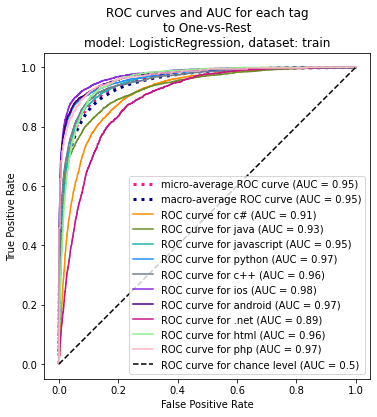

In [79]:
plot_roc_curves(
    fpr,tpr,roc_auc,'LogisticRegression', 'train',y_train, y_pred_train_proba)

In [80]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.94
Macro-averaged One-vs-Rest ROC AUC score:
0.94


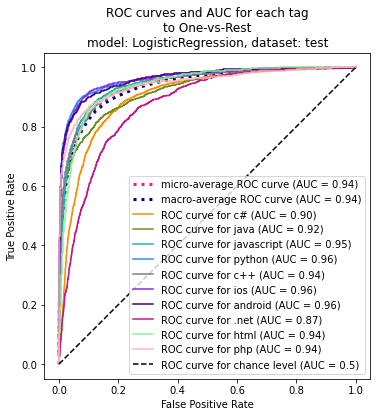

In [81]:
plot_roc_curves(
    fpr,tpr,roc_auc,'LogisticRegression', 'test',y_test, y_pred_test_proba)

### Naive-Bayes classifier (TD-IDF)

In [84]:
parameters = {
    'estimator__alpha' : [0.05, 0.2, 0.5, 1],
    'estimator__fit_prior' : [True, False]
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(MultinomialNB())

# Grid search for best hyperparameters
grid_search = GridSearchCV(
    estimator = cl,
    param_grid= parameters,
    scoring='roc_auc_ovr',
    verbose=2,
    n_jobs=-1
)

# Performing grid search
grid_search.fit(X_train, y_train)

# Instantiating Best OneVsRest Classifier
cl = grid_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
print(f'fit time: {finish - start} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

# Print best parameters
print('The best parameters are:')
print(grid_search.best_params_)
print('The best score is:')
print(grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   0.1s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   0.1s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   0.1s
[CV] END ....estimator__alpha=0.2, estimator__fit_prior=True; total time=   0.1s
[CV] END ....estimator__alpha=0.2, estimator__fit_prior=True; total time=   0.1s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   0.2s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   0.1s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   0.2s
[CV] END ....estimator__alpha=0.2, estimator__fit_prior=True; total time=   0.2s
[CV] END ....estimator__alpha=0.2, estimator__fit_prior=True; total time=   0.1s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   0.1s
[CV] END ....estimator__alpha=0.2, estimator__fit

ValueError: 
All the 40 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ana/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ana/.local/lib/python3.10/site-packages/sklearn/multiclass.py", line 327, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose)(
  File "/home/ana/.local/lib/python3.10/site-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/ana/.local/lib/python3.10/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/ana/.local/lib/python3.10/site-packages/joblib/parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/ana/.local/lib/python3.10/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/home/ana/.local/lib/python3.10/site-packages/joblib/_parallel_backends.py", line 597, in __init__
    self.results = batch()
  File "/home/ana/.local/lib/python3.10/site-packages/joblib/parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
  File "/home/ana/.local/lib/python3.10/site-packages/joblib/parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
  File "/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/fixes.py", line 117, in __call__
    return self.function(*args, **kwargs)
  File "/home/ana/.local/lib/python3.10/site-packages/sklearn/multiclass.py", line 83, in _fit_binary
    estimator.fit(X, y)
  File "/home/ana/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py", line 726, in fit
    self._count(X, Y)
  File "/home/ana/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py", line 851, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/home/ana/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1372, in check_non_negative
    raise ValueError("Negative values in data passed to %s" % whom)
ValueError: Negative values in data passed to MultinomialNB (input X)


In [86]:
from sklearn.preprocessing import MinMaxScaler

X = embeddings

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Defining target vector
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,y, test_size=0.33, random_state=5
)

In [88]:
parameters = {
    'estimator__alpha' : [0.05, 0.2, 0.5, 1],
    'estimator__fit_prior' : [True, False]
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(MultinomialNB())

# Grid search for best hyperparameters
grid_search = GridSearchCV(
    estimator = cl,
    param_grid= parameters,
    scoring='roc_auc_ovr',
    verbose=2,
    n_jobs=-1
)

# Performing grid search
grid_search.fit(X_train, y_train)

# Instantiating Best OneVsRest Classifier
cl = grid_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
print(f'fit time: {finish - start} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

# Print best parameters
print('The best parameters are:')
print(grid_search.best_params_)
print('The best score is:')
print(grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   3.2s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   3.2s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   3.1s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   3.0s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   2.8s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   3.7s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   2.9s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   3.5s
[CV] END ....estimator__alpha=0.2, estimator__fit_prior=True; total time=   2.8s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   3.1s
[CV] END ....estimator__alpha=0.2, estimator__fit_prior=True; total time=   3.2s
[CV] END ....estimator__alpha=0.2, estimator__fit

In [89]:
# Choosing best threshold for classification
thresh = choose_best_thres(y_train, y_pred_train_proba)

# predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.1


#### Evaluation: NaiveBayes

Classifier: MultinomialNB	Dataset: train
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.19      1.00      0.32      4019
        java       0.18      0.99      0.30      3584
  javascript       0.23      0.98      0.38      3119
      python       0.18      0.99      0.30      3092
         c++       0.29      0.88      0.44      2496
         ios       0.40      0.78      0.53      2208
     android       0.38      0.68      0.49      1928
        .net       0.24      0.61      0.35      2060
        html       0.42      0.60      0.49      1382
         php       0.42      0.26      0.32      1317

   micro avg       0.22      0.85      0.36     25205
   macro avg       0.29      0.78      0.39     25205
weighted avg       0.26      0.85      0.38     25205
 samples avg       0.23      0.86      0.35     25205



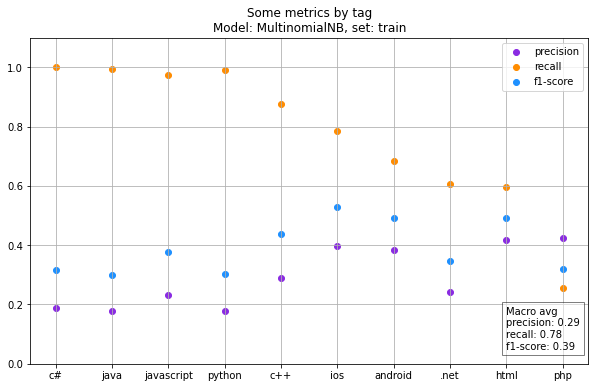

In [90]:
diplay_and_plot_report(y_train, y_pred_train, 'MultinomialNB', 'train')

Classifier: MultinomialNB	Dataset: test
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.18      1.00      0.31      1920
        java       0.18      0.99      0.30      1761
  javascript       0.24      0.98      0.38      1592
      python       0.17      0.99      0.28      1430
         c++       0.30      0.86      0.45      1276
         ios       0.39      0.75      0.52      1123
     android       0.40      0.72      0.52       974
        .net       0.24      0.60      0.34      1002
        html       0.43      0.58      0.49       745
         php       0.45      0.26      0.33       634

   micro avg       0.22      0.84      0.35     12457
   macro avg       0.30      0.77      0.39     12457
weighted avg       0.27      0.84      0.38     12457
 samples avg       0.23      0.85      0.35     12457



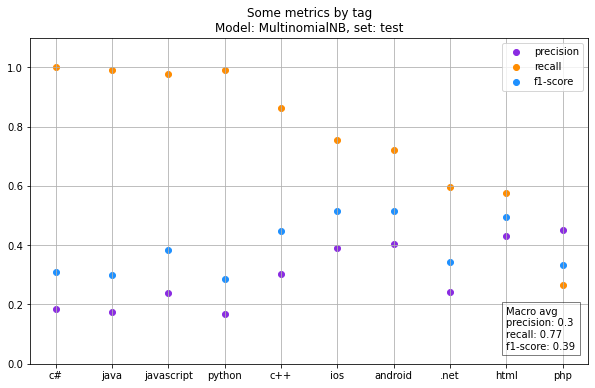

In [91]:
diplay_and_plot_report(y_test, y_pred_test, 'MultinomialNB', 'test')

In [92]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.83
Macro-averaged One-vs-Rest ROC AUC score:
0.87


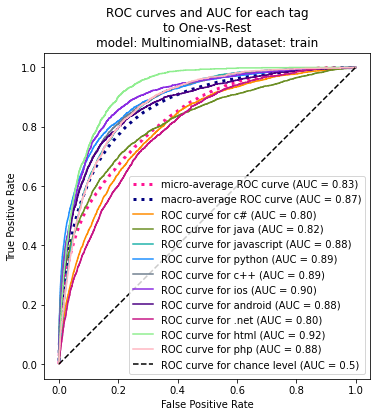

In [93]:
plot_roc_curves(
    fpr,tpr,roc_auc,'MultinomialNB', 'train',y_train, y_pred_train_proba)

In [94]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.83
Macro-averaged One-vs-Rest ROC AUC score:
0.86


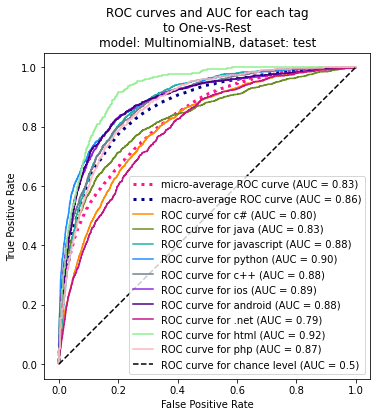

In [95]:
plot_roc_curves(
    fpr,tpr,roc_auc,'MultinomialNB', 'test',y_test, y_pred_test_proba)